In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [2]:
import pandas as pd
import numpy as np
from nltk.stem import PorterStemmer #normalize word form
from nltk.probability import FreqDist #frequency word count
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords #stop words
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.probability import FreqDist 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import string
import re


In [4]:
train_t= pd.read_csv('../input/nlp-getting-started/train.csv')
test_t=pd.read_csv('../input/nlp-getting-started/test.csv')

In [5]:
train_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train_t.keyword = train_t.keyword.fillna("unknown")
train_t.location = train_t.location.fillna("unknown")

In [7]:
train_t.keyword = train_t.keyword.apply(lambda x: x.lower())

In [8]:
train_t.keyword = train_t.keyword.apply(lambda x: x.split('%20') if "%20" in x else x )

In [9]:
ps = PorterStemmer()
wnl = WordNetLemmatizer()
key_word = []

for i,x in enumerate(train_t.keyword.values):
    
    try:
        
        a = wnl.lemmatize(ps.stem(x))

        
    except AttributeError:
        
        a = [wnl.lemmatize(ps.stem(st)) for j,st in enumerate(x)]
    
    key_word.append(a)

In [10]:
train_t.keyword = key_word

In [11]:
train_t.keyword = train_t.keyword.apply(lambda x: ''.join(x) if type(x) is list else x)

In [12]:
len(train_t.keyword.unique())

167

In [13]:
train_t.keyword.value_counts()

fatal          120
evacu          112
derail         112
flood          109
bodibag        107
              ... 
bushfire        25
warzone         24
epicentr        12
threat          11
radiatemerg      9
Name: keyword, Length: 167, dtype: int64

In [14]:
idx_val = train_t.keyword.value_counts().index.values
key_counts = train_t.keyword.value_counts().values

([<matplotlib.axis.YTick at 0x7fd928b307b8>,
 <a list of 167 Text yticklabel objects>)

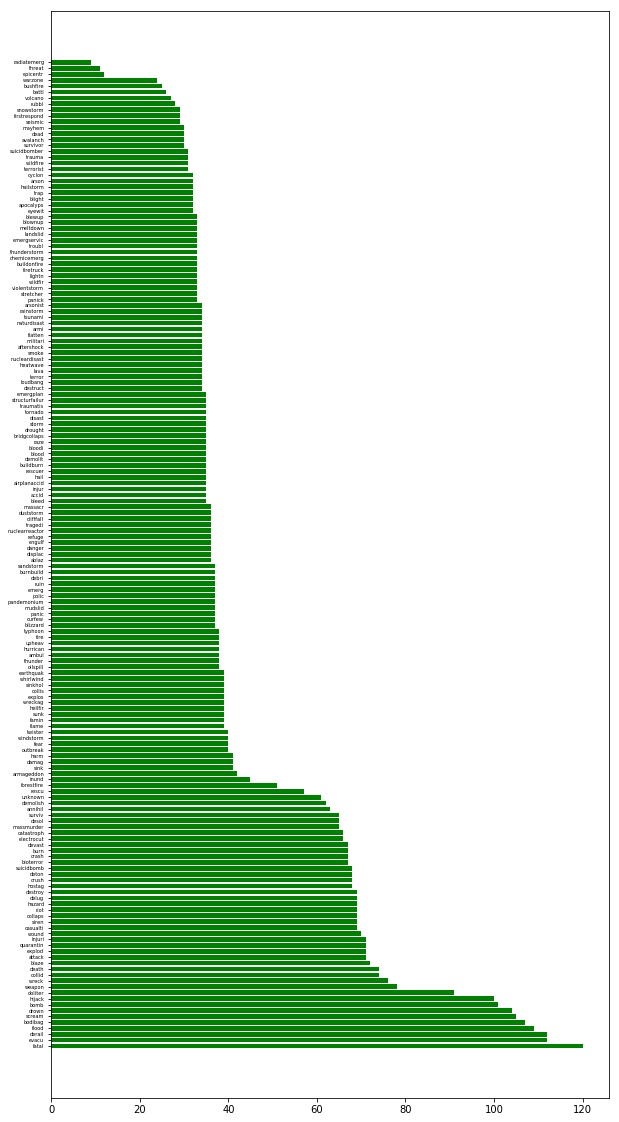

In [15]:
plt.figure(figsize=(10,20))
plt.barh(idx_val, key_counts, color='green')
plt.yticks(range(len(idx_val)),fontsize = 5)

In [16]:

train_t.groupby(['keyword','target']).agg('count')['id']

keyword     target
ablaz       0         23
            1         13
accid       0         11
            1         24
aftershock  0         34
                      ..
wound       0         34
            1         36
wreck       0         66
            1         10
wreckag     1         39
Name: id, Length: 331, dtype: int64

In [17]:
train_t[train_t.target ==1].keyword.value_counts().to_frame()

,keyword
evacu,85
derail,82
flood,66
suicidbomb,64
fatal,62
...,...
blewup,2
blight,2
threat,2
ruin,1


In [18]:
train_t[train_t.target ==0].keyword.value_counts().to_frame()

,keyword
bodibag,100
scream,94
obliter,79
drown,77
wreck,66
...,...
nucleardisast,3
oilspill,1
typhoon,1
suicidbomber,1


In [19]:
key_target_counts = train_t[train_t.target ==1].keyword.value_counts().to_frame().join(train_t[train_t.target ==0].keyword.value_counts().to_frame(), lsuffix='_1', rsuffix='_0',how = 'outer')

In [20]:
key_target_counts.columns = ['target_1','target_0']

In [21]:
key_target_counts = key_target_counts.fillna(0)

In [22]:
key_target_counts

,target_1,target_0
ablaz,13.0,23.0
accid,24.0,11.0
aftershock,0.0,34.0
airplanaccid,30.0,5.0
ambul,20.0,18.0
...,...,...
wildfire,27.0,4.0
windstorm,16.0,24.0
wound,36.0,34.0
wreck,10.0,66.0


In [23]:
key_target_counts.sort_values(by=['target_1','target_0'],ascending=False,inplace = True)

In [24]:
key_target_counts['target_1_ratio'] = key_target_counts.target_1 / (key_target_counts.target_1 +key_target_counts.target_0)
key_target_counts['target_0_ratio'] = key_target_counts.target_0 / (key_target_counts.target_1 +key_target_counts.target_0)

In [25]:
key_target_counts.sort_values(by=['target_1_ratio','target_0_ratio'],ascending=False,inplace = True)

In [26]:
key_target_counts #target 1 ratio

,target_1,target_0,target_1_ratio,target_0_ratio
wreckag,39.0,0.0,1.000000,0.000000
debri,37.0,0.0,1.000000,0.000000
outbreak,39.0,1.0,0.975000,0.025000
oilspill,37.0,1.0,0.973684,0.026316
typhoon,37.0,1.0,0.973684,0.026316
...,...,...,...,...
blewup,2.0,31.0,0.060606,0.939394
panick,2.0,31.0,0.060606,0.939394
traumatis,2.0,33.0,0.057143,0.942857
ruin,1.0,36.0,0.027027,0.972973


In [27]:
key_target_counts.describe()

,target_1,target_0,target_1_ratio,target_0_ratio
count,167.000000,167.000000,167.000000,167.000000
mean,19.586826,26.000000,0.434712,0.565288
std,15.162670,17.767237,0.266842,0.266842
min,0.000000,0.000000,0.000000,0.000000
25%,8.000000,12.500000,0.192928,0.333333
50%,17.000000,24.000000,0.405797,0.594203
75%,27.000000,33.500000,0.666667,0.807072
max,85.000000,100.000000,1.000000,1.000000


In [28]:
train_t[train_t.keyword == 'unknown'] #for the unknown keyword twitter, check if text contain keyword in keyword list

,id,keyword,location,text,target
0,1,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,unknown,unknown,Forest fire near La Ronge Sask. Canada,1
2,5,unknown,unknown,All residents asked to 'shelter in place' are ...,1
3,6,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,unknown,unknown,Two giant cranes holding a bridge collapse int...,1
7609,10870,unknown,unknown,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,unknown,unknown,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,unknown,unknown,Police investigating after an e-bike collided ...,1


In [29]:
k_1 = key_target_counts[key_target_counts['target_1_ratio']>=0.2].index.values #keywords
k_1_r = key_target_counts[key_target_counts['target_1_ratio']>=0.2]['target_1_ratio'].values #ratio
k_0 = key_target_counts[key_target_counts['target_0_ratio']>=0.2].index.values #keywords
k_0_r = key_target_counts[key_target_counts['target_0_ratio']>=0.2]['target_0_ratio'].values #ratio

([<matplotlib.axis.YTick at 0x7fd922101c18>,
 <a list of 123 Text yticklabel objects>)

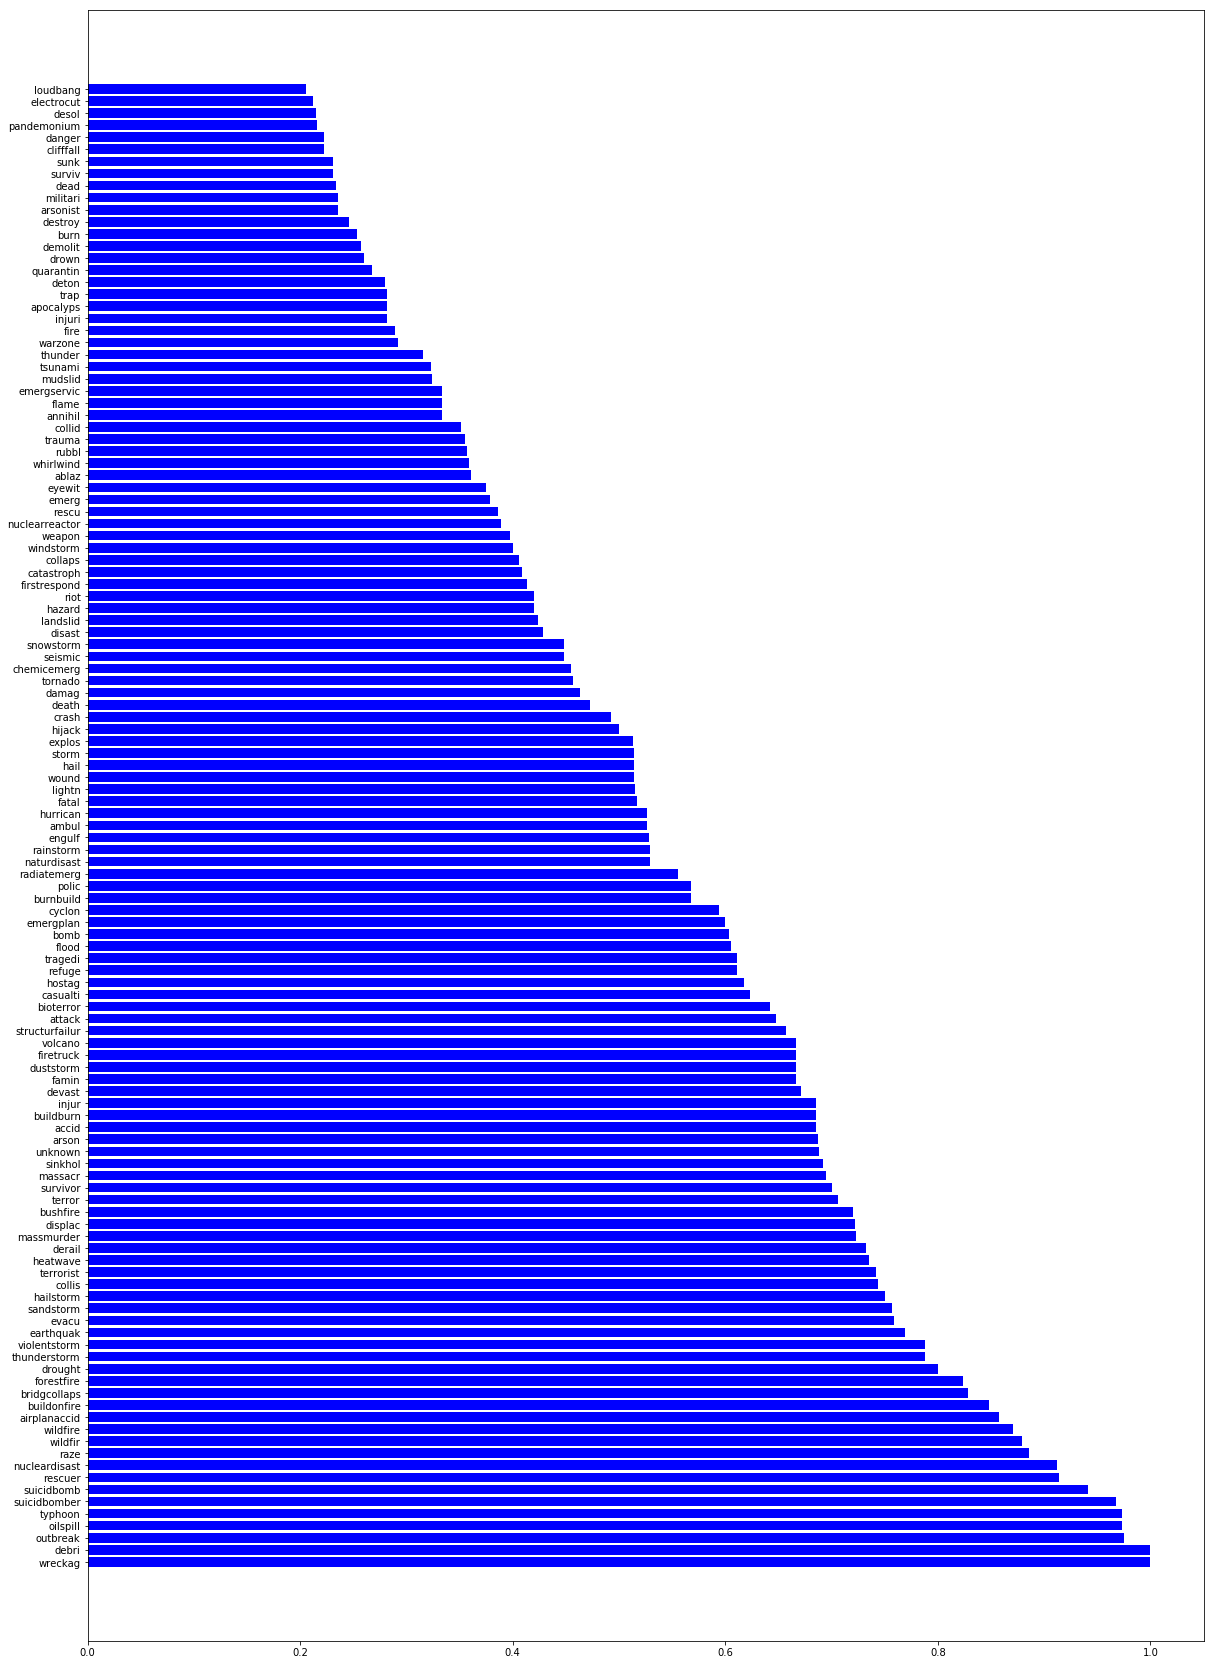

In [30]:
plt.figure(figsize=(20,30))
plt.barh(k_1, k_1_r, color='blue')
plt.yticks(range(len(k_1)),fontsize = 10)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150],
 <a list of 151 Text yticklabel objects>)

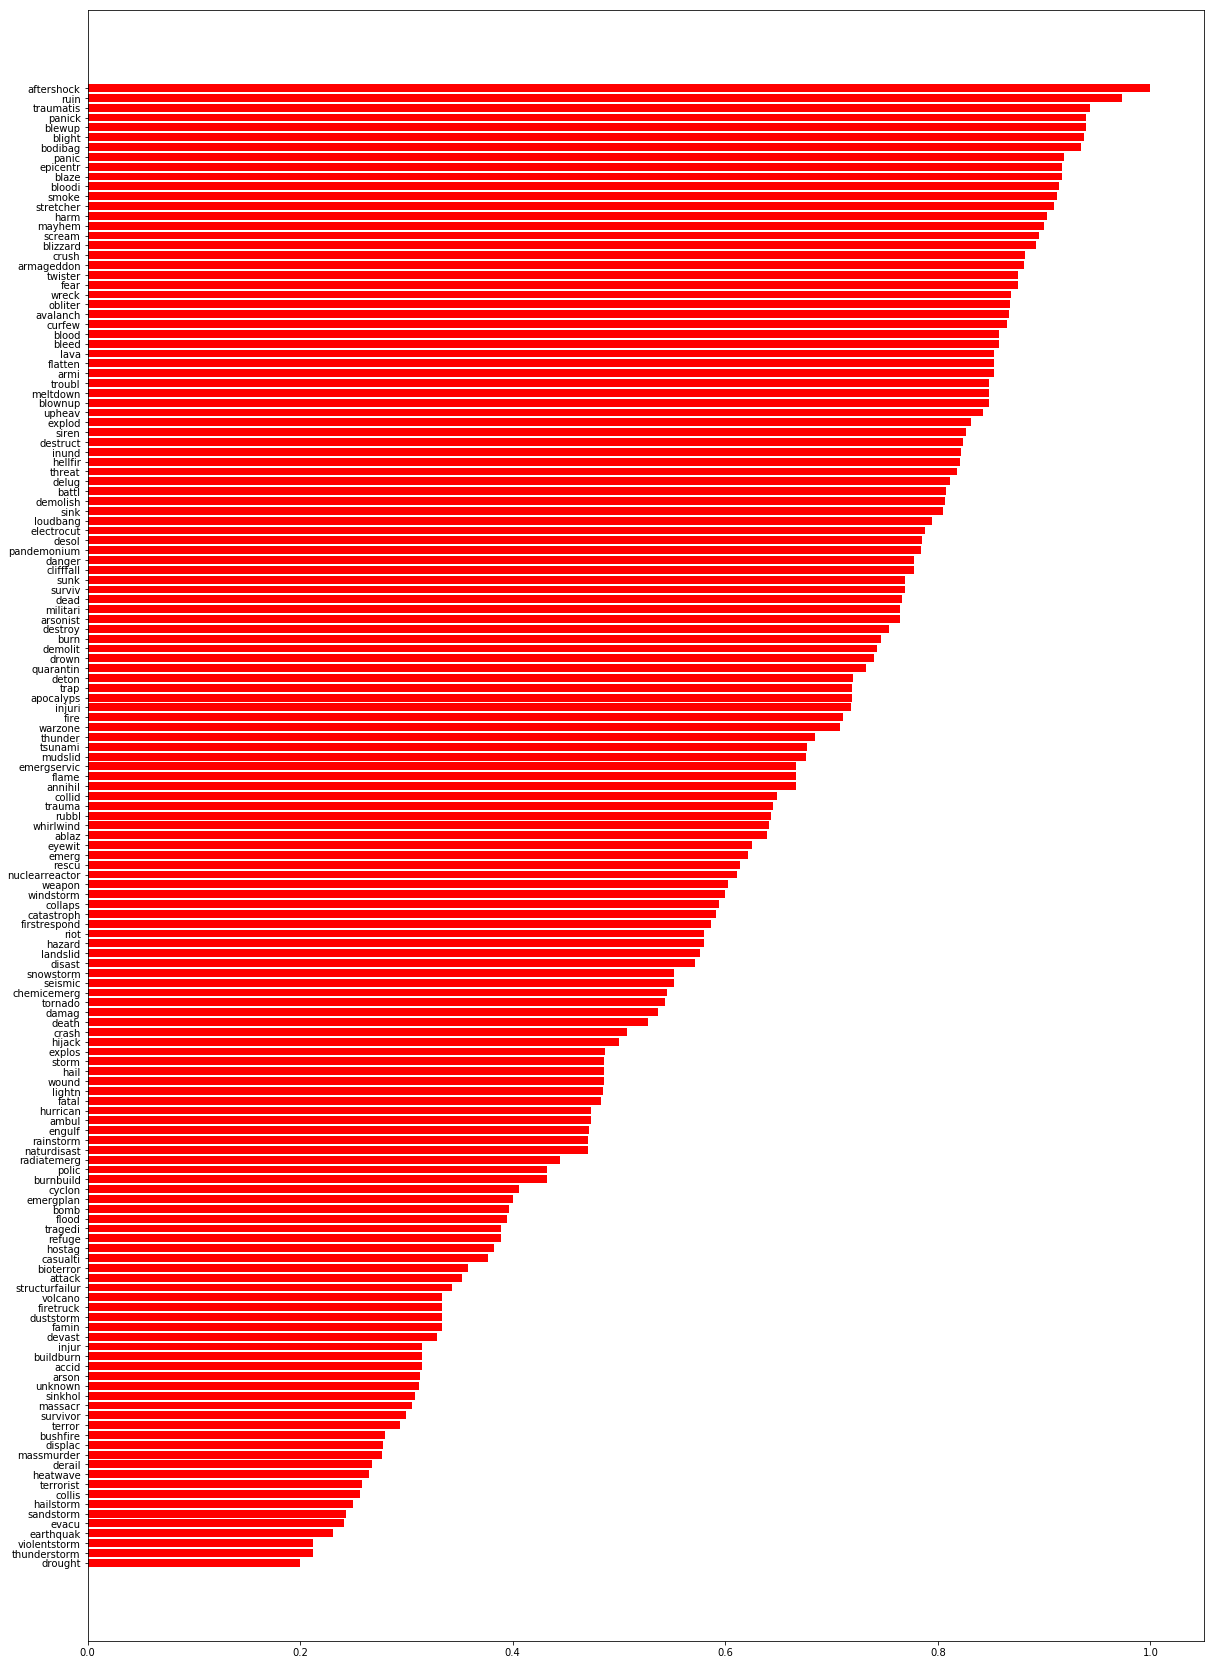

In [31]:
plt.figure(figsize=(20,30))
plt.barh(k_0, k_0_r, color='red')
plt.yticks(fontsize = 10)

In [32]:
list(train_t.location.unique())

['unknown',
 'Birmingham',
 'Est. September 2012 - Bristol',
 'AFRICA',
 'Philadelphia, PA',
 'London, UK',
 'Pretoria',
 'World Wide!!',
 'Paranaque City',
 'Live On Webcam',
 'milky way',
 'GREENSBORO,NORTH CAROLINA',
 'England.',
 'Sheffield Township, Ohio',
 'India',
 'Barbados',
 'Anaheim',
 'Abuja',
 'USA',
 'South Africa',
 'Sao Paulo, Brazil',
 'hollywoodland ',
 'Edmonton, Alberta - Treaty 6',
 'Inang Pamantasan',
 'Twitter Lockout in progress',
 'Concord, CA',
 'Calgary, AB',
 'San Francisco',
 'CLVLND',
 'Nashville, TN',
 'Santa Clara, CA',
 'UK',
 'St. Louis, MO',
 'Walker County, Alabama',
 'Australia',
 'North Carolina',
 'Norf Carolina',
 'San Mateo County, CA',
 'Njoro, Kenya',
 "Your Sister's Bedroom",
 'Arlington, TX',
 'South Bloomfield, OH',
 'New Hanover County, NC',
 'Maldives',
 'Manchester, NH',
 'Wilmington, NC',
 'global',
 'Alberta | Sask. | Montana',
 'Charlotte',
 'Baton Rouge, LA',
 'Hagerstown, MD',
 'Gloucestershire , UK',
 'Nairobi, Kenya',
 'Instagram 

In [33]:
def text_cleaning_hyperlink(text):
    
    #remove hyper link
    return re.sub(r"http\S+","",text) #remove hyperlink

In [34]:
def text_cleaning_punctuation(text):
    
    translator = str.maketrans('', '', string.punctuation) #remove punctuation
    
    return text.translate(translator)

In [35]:
def text_cleaning_stopwords(text):
    
    stop_words = set(stopwords.words('english'))
    
    word_token = word_tokenize(text)
    
    filtered_sentence = [w for w in word_token if not w in stop_words]
    
    return ' '.join(filtered_sentence) #return string of no stopwords


In [36]:
def text_cleaning_lowercase(text):
    
    return text.lower()

In [37]:
def find_synonyms(word):
    
    synonyms = []
    
    for syn in wordnet.synsets(word):
        for lm in syn.lemmas():
            
            synonyms.append(lm.name())
    
    if len(synonyms)>0:
        return set(synonyms) #exist synoyms
    
    else:
        return set([word]) #not exist synoyms
  

#Reference: https://towardsdatascience.com/synonyms-and-antonyms-in-python-a865a5e14ce8

In [38]:
def text_extract(text_lst):
    txt = []
    for i,x in enumerate(text_lst):
        
        for j,p in enumerate(x):
            
            txt.append(p)
    
    return txt
    

In [39]:
train_t.text = train_t.text.apply(lambda x: text_cleaning_stopwords(text_cleaning_punctuation(text_cleaning_hyperlink(x.lower()))))

In [40]:
train_t.text =train_t.text.apply(lambda x: set(x.split(' ')))

In [41]:
true_txt = train_t[train_t['target']==1].text.values

In [42]:
true_txt_lst = text_extract(true_txt)

In [43]:
fdist_true = FreqDist(true_txt_lst)

In [44]:
fdist_true.most_common()

[('fire', 162),
 ('news', 130),
 ('via', 121),
 ('california', 108),
 ('suicide', 104),
 ('people', 101),
 ('police', 97),
 ('disaster', 96),
 ('amp', 95),
 ('killed', 90),
 ('like', 88),
 ('hiroshima', 84),
 ('fires', 82),
 ('storm', 82),
 ('crash', 78),
 ('us', 77),
 ('emergency', 75),
 ('train', 74),
 ('buildings', 74),
 ('bomb', 73),
 ('wildfire', 69),
 ('mh370', 69),
 ('nuclear', 68),
 ('2', 67),
 ('video', 67),
 ('get', 66),
 ('accident', 66),
 ('two', 65),
 ('bombing', 65),
 ('attack', 64),
 ('northern', 64),
 ('burning', 63),
 ('one', 62),
 ('dead', 60),
 ('pm', 58),
 ('bomber', 57),
 ('still', 56),
 ('families', 56),
 ('homes', 56),
 ('new', 55),
 ('atomic', 55),
 ('war', 55),
 ('car', 54),
 ('fatal', 54),
 ('years', 53),
 ('im', 52),
 ('collapse', 51),
 ('watch', 50),
 ('debris', 49),
 ('dont', 49),
 ('may', 48),
 ('first', 48),
 ('malaysia', 48),
 ('forest', 47),
 ('latest', 47),
 ('japan', 47),
 ('mass', 47),
 ('near', 46),
 ('today', 46),
 ('water', 46),
 ('man', 45),
 ('r

In [45]:
false_txt = train_t[train_t['target']==0].text
false_txt_lst = text_extract(false_txt)
fdist_false = FreqDist(false_txt_lst)

In [46]:
fdist_false.most_common()

[('like', 240),
 ('im', 221),
 ('amp', 174),
 ('new', 163),
 ('get', 158),
 ('dont', 136),
 ('one', 122),
 ('body', 111),
 ('via', 96),
 ('would', 93),
 ('people', 90),
 ('video', 90),
 ('got', 88),
 ('know', 84),
 ('love', 81),
 ('2', 81),
 ('full', 81),
 ('time', 80),
 ('back', 79),
 ('cant', 77),
 ('see', 77),
 ('emergency', 77),
 ('us', 76),
 ('youtube', 76),
 ('day', 74),
 ('going', 73),
 ('still', 70),
 ('fire', 68),
 ('go', 67),
 ('good', 65),
 ('want', 64),
 ('think', 63),
 ('world', 61),
 ('3', 60),
 ('lol', 60),
 ('man', 59),
 ('rt', 59),
 ('life', 59),
 ('na', 59),
 ('first', 58),
 ('news', 56),
 ('last', 54),
 ('work', 54),
 ('make', 54),
 ('really', 54),
 ('burning', 54),
 ('youre', 53),
 ('way', 53),
 ('best', 52),
 ('need', 52),
 ('many', 51),
 ('let', 51),
 ('even', 50),
 ('much', 49),
 ('u', 49),
 ('help', 48),
 ('take', 48),
 ('say', 47),
 ('right', 46),
 ('content', 46),
 ('feel', 45),
 ('hot', 45),
 ('black', 45),
 ('look', 44),
 ('god', 44),
 ('never', 44),
 ('ever

In [47]:
fdist = FreqDist(text_all)

NameError: name 'text_all' is not defined

In [48]:
sorted(fdist, key=lambda x: x[1])

NameError: name 'fdist' is not defined

In [49]:
fdist.max()

NameError: name 'fdist' is not defined

In [50]:
fdist.most_common()

NameError: name 'fdist' is not defined